In [1]:
!pip install skorch

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
import os
import sys
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from collections import defaultdict
from skorch import NeuralNetRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import PredefinedSplit

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
PATH = "/content/drive/MyDrive/solar_data"
sys.path.insert(0, PATH)

In [5]:
from GRU_model import GRUNet

In [6]:
print(sys.path)

['/content/drive/MyDrive/solar_data', '/content', '/env/python', '/usr/lib/python310.zip', '/usr/lib/python3.10', '/usr/lib/python3.10/lib-dynload', '', '/usr/local/lib/python3.10/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.10/dist-packages/IPython/extensions', '/root/.ipython']


In [7]:
WINDOW_SIZE = 25

In [8]:
#TODO make supervised learning dataset from csv files
#TODO build dataloader
solar_data = np.genfromtxt('/content/drive/MyDrive/solar_data/data/training_data/train_solar.csv', delimiter=',', skip_header=1)
wind_data = np.genfromtxt('/content/drive/MyDrive/solar_data/data/training_data/train_wind.csv', delimiter=',',skip_header=1)
solar_data_val = np.genfromtxt('/content/drive/MyDrive/solar_data/data/training_data/val_solar.csv', delimiter=',', skip_header=1)
wind_data_val = np.genfromtxt('/content/drive/MyDrive/solar_data/data/training_data/val_wind.csv', delimiter=',', skip_header=1)


In [9]:
solar_data.shape, wind_data.shape

((17544, 11), (17544, 11))

In [10]:
def move_sliding_window(data, window_size, inputs_cols_indices, label_col_index):
    """
    data: numpy array including data
    window_size: size of window
    inputs_cols_indices: col indices to include
    """

    # (# instances created by movement, seq_len (timestamps), # features (input_len))
    inputs = np.zeros((len(data) - window_size, window_size, len(inputs_cols_indices)))
    labels = np.zeros(len(data) - window_size)

    for i in range(window_size, len(data)):
        inputs[i - window_size] = data[i - window_size : i, inputs_cols_indices]
        labels[i - window_size] = data[i, label_col_index]
    inputs = inputs.reshape(-1, window_size, len(inputs_cols_indices))
    labels = labels.reshape(-1, 1)
    print(inputs.shape, labels.shape)

    return inputs, labels

In [11]:
#24 hours ahead data for wind and solar supply
def move_sliding_window_2(data, window_size, inputs_cols_indices, label_col_index, forecast_horizon=24):
    """
    data: numpy array including data
    window_size: size of window
    inputs_cols_indices: col indices to include
    label_col_index: index of the label column in data
    forecast_horizon: number of time steps ahead to predict
    """

    # Calculate the number of instances based on the available data minus the window size and forecast horizon
    num_instances = len(data) - window_size - forecast_horizon + 1

    # (# instances created by movement, seq_len (timestamps), # features (input_len))
    inputs = np.zeros((num_instances, window_size, len(inputs_cols_indices)))
    labels = np.zeros(num_instances)

    for i in range(num_instances):
        inputs[i] = data[i:i + window_size, inputs_cols_indices]
        labels[i] = data[i + window_size + forecast_horizon - 1, label_col_index]  # Label is forecast_horizon steps ahead
    inputs = inputs.reshape(-1, window_size, len(inputs_cols_indices))
    labels = labels.reshape(-1, 1)
    print(inputs.shape, labels.shape)

    return inputs, labels

In [12]:
#create dataset
class SolarDataset(Dataset):
    def __init__(self, inputs, output):
        self.inputs = inputs
        self.output = output

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return self.inputs[idx], self.output[idx]

In [13]:
def combine_datasets(train_X, train_y, val_X, val_y):
  combined_X = np.concatenate((train_X, val_X), axis=0)
  combined_y = np.concatenate((train_y, val_y), axis=0)

  combined_X = torch.tensor(combined_X, dtype=torch.float32)
  combined_y = torch.tensor(combined_y, dtype=torch.float32)

  train_indices = [-1] * len(train_X)
  val_indices = [0] * len(val_X)

  test_fold = np.array(train_indices + val_indices)

  return combined_X, combined_y, PredefinedSplit(test_fold)

In [25]:
solar_X, solar_y = move_sliding_window(solar_data, WINDOW_SIZE, range(11), 0)
wind_X, wind_y = move_sliding_window(wind_data, WINDOW_SIZE, range(11), 0)
solar_X_val, solar_y_val = move_sliding_window(solar_data_val, WINDOW_SIZE, range(11), 0)
wind_X_val, wind_y_val = move_sliding_window(wind_data_val, WINDOW_SIZE, range(11), 0)


(17519, 25, 11) (17519, 1)
(17519, 25, 11) (17519, 1)
(8735, 25, 11) (8735, 1)
(8735, 25, 11) (8735, 1)


In [13]:
solar_dataset = SolarDataset(solar_X, solar_y)
wind_dataset = SolarDataset(wind_X, wind_y)
dataloader_solar = DataLoader(solar_dataset, batch_size=32, shuffle=False, drop_last=True)
dataloader_wind = DataLoader(wind_dataset, batch_size=32, shuffle=False, drop_last=True)



In [18]:
solar_dataset_val = SolarDataset(solar_X_val, solar_y_val)
dataloader_solar_val = DataLoader(solar_dataset_val, batch_size=32, shuffle=False, drop_last=True)

(8735, 25, 11) (8735, 1)


In [20]:
wind_dataset_val = SolarDataset(wind_X_val, wind_y_val)
dataloader_wind_val = DataLoader(wind_dataset_val, batch_size=32, shuffle=False, drop_last=True)

(8735, 25, 11) (8735, 1)


In [ ]:
alpha = 2
N_h = solar_data.shape[0] / (alpha * (11 + 1))
print(N_h)

731.0


In [23]:
INPUT_SIZE = solar_data.shape[1]
HIDDEN_SIZE = 16
NUM_LAYERS = 2
OUTPUT_SIZE = 1
DROP_PROB = .5
lr = 0.001

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GRUNet(input_dim=INPUT_SIZE, hidden_dim=HIDDEN_SIZE, output_dim=OUTPUT_SIZE, n_layers=NUM_LAYERS, drop_prob=DROP_PROB).to(device)
model

GRUNet(
  (gru): GRU(11, 16, num_layers=2, batch_first=True, dropout=0.5)
  (fc): Linear(in_features=16, out_features=1, bias=True)
)

In [21]:
# Initialize PredefinedSplit
solar_X_combined, solar_y_combined, ps = combine_datasets(solar_X, solar_y, solar_X_val, solar_y_val)
wind_X_combined, wind_y_combined, ps_wind = combine_datasets(wind_X, wind_y, wind_X_val, wind_y_val)

In [ ]:
net = NeuralNetRegressor(
    module=GRUNet,
    module__input_dim=INPUT_SIZE,
    module__output_dim=OUTPUT_SIZE,
    criterion=torch.nn.MSELoss,
    optimizer=torch.optim.Adam,
    device=device  # or 'cpu'
)

# Define the parameter grid
params = {
    'module__hidden_dim': [16, 32, 64],
    'module__n_layers': [1, 2],
    'module__drop_prob': [0.5],
    'optimizer__lr': [0.001],
    'optimizer__weight_decay': [0.0001, 0.001],
    'max_epochs': [80],
    'batch_size': [16, 32, 64],
    'iterator_train__shuffle': [False],
}

In [ ]:
gs = GridSearchCV(net, params, refit=False, cv=ps, scoring='neg_mean_squared_error', verbose=2)
gs.fit(solar_X_combined, solar_y_combined)

Fitting 1 folds for each of 36 candidates, totalling 36 fits


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.0948        0.2153  2.2034
      2        0.0625        0.1325  2.7707
      3        0.0562        0.1292  2.4129
      4        0.0552        0.1264  2.1479
      5        0.0546        0.1275  2.1692
      6        0.0548        0.1270  2.1876
      7        0.0554        0.1287  2.1668
      8        0.0546        0.1278  2.7786
      9        0.0545        0.1262  2.3871
     10        0.0537        0.1248  2.2096
     11        0.0531        0.1201  2.1636
     12        0.0527        0.1174  2.1666
     13        0.0517        0.1176  2.2172
     14        0.0522        0.1176  2.9174
     15        0.0522        0.1196  3.1578
     16        0.0543        0.0994  2.3695
     17        0.0510        0.1067  2.1755
     18        0.0506        0.0791  2.2104
     19        0.0485        0.0814  2.1617
     20        0.0471        0.0763  2.7307
     21        0.0454        0.0

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.0801        0.3229  2.1480
      2        0.0820        0.3056  2.1755
      3        0.0751        0.2010  2.1739
      4        0.0560        0.1478  2.1355
      5        0.0539        0.1453  2.5364
      6        0.0549        0.1418  2.6143
      7        0.0581        0.1619  2.1697
      8        0.0582        0.1738  2.1712
      9        0.0578        0.1771  2.1055
     10        0.0571        0.1740  2.1321
     11        0.0568        0.1770  2.5988
     12        0.0557        0.1708  2.6144
     13        0.0571        0.1727  2.1291
     14        0.0574        0.1719  2.1241
     15        0.0574        0.1707  2.1755
     16        0.0575        0.1740  2.2694
     17        0.0570        0.1675  2.5893
     18        0.0567        0.1829  2.5743
     19        0.0570        0.1825  2.1421
     20        0.0594        0.1820  2.1328
     21        0.0565        0.1

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.0695        0.1772  2.2672
      2        0.0574        0.2018  2.7941
      3        0.0566        0.1620  2.2234
      4        0.0550        0.2003  2.1385
      5        0.0543        0.1797  2.1362
      6        0.0523        0.1782  2.1423
      7        0.0526        0.1681  2.3066
      8        0.0517        0.1599  2.8458
      9        0.0517        0.1617  2.1487
     10        0.0510        0.1400  2.1121
     11        0.0538        0.1569  2.1112
     12        0.0515        0.1561  2.1349
     13        0.0519        0.1595  2.3102
     14        0.0537        0.1679  2.7981
     15        0.0546        0.1673  2.1861
     16        0.0526        0.1621  2.1673
     17        0.0517        0.1483  2.1480
     18        0.0500        0.1392  2.1528
     19        0.0494        0.1383  2.3267
     20        0.0526        0.1404  2.8064
     21        0.0521        0.1

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.0749        0.2268  2.1339
      2        0.0569        0.1551  2.1695
      3        0.0563        0.1568  2.1380
      4        0.0544        0.1667  2.1448
      5        0.0550        0.1996  2.7573
      6        0.0543        0.1611  2.3541
      7        0.0541        0.1650  2.1591
      8        0.0537        0.1730  2.1530
      9        0.0551        0.1715  2.1329
     10        0.0544        0.1798  2.2467
     11        0.0543        0.1648  2.7710
     12        0.0552        0.1806  2.3129
     13        0.0545        0.1927  2.1404
     14        0.0554        0.1767  2.1457
     15        0.0552        0.1797  2.5365
     16        0.0543        0.1752  2.9351
     17        0.0550        0.1811  2.8114
     18        0.0554        0.1836  2.1450
     19        0.0555        0.1832  2.1554
     20        0.0584        0.2586  2.1588
     21        0.0607        0.1

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.0707        0.2310  2.1560
      2        0.0602        0.2225  2.1399
      3        0.0582        0.2294  2.5867
      4        0.0566        0.2321  2.5787
      5        0.0550        0.2225  2.1559
      6        0.0543        0.2269  2.1159
      7        0.0568        0.2751  2.1442
      8        0.0580        0.2397  2.1467
      9        0.0545        0.2096  2.5943
     10        0.0527        0.1917  2.5241
     11        0.0518        0.1861  2.1600
     12        0.0488        0.1830  2.1383
     13        0.0454        0.1287  2.1195
     14        0.0367        0.0908  2.1631
     15        0.0251        0.1028  2.5687
     16        0.0172        0.1283  2.5787
     17        0.0150        0.1277  2.1530
     18        0.0129        0.1133  2.1370
     19        0.0118        0.1015  2.1495
     20        0.0100        0.0713  2.1485
     21        0.0072        0.1

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.0889        0.2362  2.7358
      2        0.0847        0.2408  2.1517
      3        0.0851        0.2927  2.1306
      4        0.0794        0.2821  2.1535
      5        0.0676        0.2432  2.1374
      6        0.0639        0.2857  2.3956
      7        0.0627        0.2855  2.7022
      8        0.0621        0.2981  2.1791
      9        0.0621        0.2953  2.1804
     10        0.0629        0.2618  2.1565
     11        0.0614        0.2846  2.1835
     12        0.0619        0.2845  2.5265
     13        0.0620        0.2849  2.6510
     14        0.0621        0.2847  2.1378
     15        0.0622        0.2826  2.1309
     16        0.0619        0.2805  2.1356
     17        0.0619        0.2800  2.1520
     18        0.0619        0.2783  2.5030
     19        0.0618        0.2681  2.6628
     20        0.0620        0.2667  2.1458
     21        0.0618        0.2

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.0955        0.2214  1.2367
      2        0.0846        0.1512  1.4650
      3        0.0718        0.1511  1.5295
      4        0.0675        0.1290  1.2686
      5        0.0656        0.1249  1.1354
      6        0.0649        0.1294  1.1313
      7        0.0676        0.1247  1.1404
      8        0.0672        0.1235  1.1745
      9        0.0668        0.1218  1.1358
     10        0.0674        0.1223  1.1483
     11        0.0675        0.1219  1.1407
     12        0.0653        0.1243  1.1828
     13        0.0685        0.1221  1.5008
     14        0.0684        0.1211  1.5178
     15        0.0684        0.1202  1.3269
     16        0.0682        0.1228  1.1353
     17        0.0688        0.1201  1.1652
     18        0.0684        0.1186  1.1512
     19        0.0671        0.1155  1.1408
     20        0.0657        0.1043  1.1359
     21        0.0639        0.0

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.0928        0.1478  1.3583
      2        0.0829        0.1611  1.1411
      3        0.0758        0.1258  1.1398
      4        0.0711        0.1267  1.1442
      5        0.0683        0.1176  1.1610
      6        0.0663        0.1123  1.1443
      7        0.0642        0.1080  1.1465
      8        0.0630        0.0935  1.1320
      9        0.0623        0.1122  1.1499
     10        0.0618        0.0855  1.4264
     11        0.0595        0.1030  1.4722
     12        0.0587        0.0856  1.4334
     13        0.0601        0.0943  1.1572
     14        0.0569        0.0910  1.1456
     15        0.0595        0.1107  1.1422
     16        0.0595        0.0987  1.1467
     17        0.0561        0.0914  1.1529
     18        0.0546        0.0889  1.1479
     19        0.0559        0.0957  1.1493
     20        0.0497        0.0929  1.1611
     21        0.0480        0.0

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.0939        0.2592  1.1481
      2        0.0941        0.3005  1.3461
      3        0.0973        0.2730  1.4918
      4        0.0918        0.1774  1.5413
      5        0.0734        0.1671  1.1566
      6        0.0710        0.1506  1.1371
      7        0.0721        0.1593  1.1269
      8        0.0709        0.1503  1.1512
      9        0.0678        0.1677  1.1772
     10        0.0677        0.1682  1.1616
     11        0.0701        0.1487  1.1580
     12        0.0691        0.1461  1.1332
     13        0.0645        0.1487  1.2728
     14        0.0677        0.1498  1.4791
     15        0.0634        0.1549  1.5218
     16        0.0627        0.1495  1.2491
     17        0.0651        0.1607  1.1477
     18        0.0652        0.1562  1.1340
     19        0.0636        0.1555  1.1430
     20        0.0650        0.1638  1.1491
     21        0.0665        0.1

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.0932        0.2372  1.4807
      2        0.0820        0.2080  1.5276
      3        0.0702        0.1739  1.2089
      4        0.0670        0.1587  1.1322
      5        0.0674        0.1644  1.1442
      6        0.0666        0.1725  1.1463
      7        0.0654        0.1745  1.1558
      8        0.0643        0.1811  1.1715
      9        0.0624        0.1956  1.1442
     10        0.0634        0.1941  1.1409
     11        0.0635        0.1916  1.2023
     12        0.0619        0.1883  1.5008
     13        0.0628        0.2009  1.4812
     14        0.0628        0.1887  1.3097
     15        0.0623        0.1907  1.1504
     16        0.0645        0.1800  1.1231
     17        0.0632        0.1921  1.1536
     18        0.0632        0.1834  1.1377
     19        0.0625        0.1885  1.1229
     20        0.0643        0.1827  1.1430
     21        0.0636        0.1

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.0882        0.2642  1.1673
      2        0.0770        0.1704  1.1483
      3        0.0671        0.1496  1.4512
      4        0.0670        0.1589  1.4764
      5        0.0688        0.1654  1.4137
      6        0.0632        0.1690  1.1361
      7        0.0640        0.1693  1.1419
      8        0.0621        0.2085  1.1592
      9        0.0659        0.1625  1.1395
     10        0.0605        0.2038  1.1213
     11        0.0634        0.1597  1.1407
     12        0.0610        0.1568  1.1491
     13        0.0599        0.1549  1.1671
     14        0.0593        0.1664  1.3960
     15        0.0615        0.1578  1.4873
     16        0.0599        0.1562  1.5043
     17        0.0613        0.1728  1.1491
     18        0.0584        0.1656  1.1408
     19        0.0583        0.1712  1.1657
     20        0.0572        0.1829  1.1453
     21        0.0577        0.1

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.0878        0.2398  1.4995
      2        0.0917        0.2517  1.5346
      3        0.0728        0.1482  1.1553
      4        0.0644        0.1901  1.1615
      5        0.0654        0.1848  1.1383
      6        0.0626        0.1828  1.1378
      7        0.0632        0.2011  1.1452
      8        0.0620        0.2030  1.1468
      9        0.0615        0.1928  1.1498
     10        0.0618        0.1831  1.1655
     11        0.0607        0.1832  1.2749
     12        0.0603        0.2169  1.4884
     13        0.0662        0.1755  1.5469
     14        0.0602        0.2231  1.1445
     15        0.0669        0.2368  1.1424
     16        0.0662        0.2186  1.1386
     17        0.0648        0.2081  1.1447
     18        0.0643        0.1850  1.1550
     19        0.0662        0.1769  1.1554
     20        0.0653        0.1830  1.1420
     21        0.0662        0.2

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.1728        0.1392  0.8575
      2        0.1147        0.1311  0.8396
      3        0.1082        0.1233  0.8930
      4        0.1013        0.1105  0.8767
      5        0.0938        0.0971  0.6444
      6        0.0878        0.0858  0.6488
      7        0.0819        0.0929  0.6431
      8        0.0786        0.0659  0.6407
      9        0.0725        0.0670  0.6436
     10        0.0682        0.0613  0.6466
     11        0.0618        0.0662  0.6399
     12        0.0585        0.0705  0.6471
     13        0.0563        0.0588  0.6378
     14        0.0503        0.0555  0.6362
     15        0.0485        0.0651  0.6387
     16        0.0486        0.0676  0.6281
     17        0.0497        0.0637  0.6235
     18        0.0477        0.0645  0.6293
     19        0.0473        0.0665  0.6729
     20        0.0464        0.0634  0.7491
     21        0.0446        0.0

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.1583        0.1338  0.8427
      2        0.1586        0.1506  0.8584
      3        0.1929        0.1276  0.8634
      4        0.1756        0.1337  0.9013
      5        0.1921        0.1287  0.6982
      6        0.1904        0.1591  0.6416
      7        0.1953        0.1390  0.6418
      8        0.1982        0.1346  0.6465
      9        0.1931        0.1250  0.6613
     10        0.1976        0.1221  0.6422
     11        0.1936        0.1196  0.6389
     12        0.1812        0.1104  0.6433
     13        0.1963        0.1120  0.6373
     14        0.1961        0.1133  0.6398
     15        0.1951        0.1072  0.6462
     16        0.2068        0.1121  0.6334
     17        0.1880        0.1000  0.6462
     18        0.1910        0.1177  0.6393
     19        0.1913        0.0980  0.6403
     20        0.1908        0.0956  0.7164
     21        0.1889        0.0

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.0893        0.1742  0.6591
      2        0.1122        0.1312  0.6717
      3        0.1093        0.1828  0.6486
      4        0.1078        0.1333  0.6576
      5        0.0950        0.1026  0.6582
      6        0.0821        0.0915  0.6421
      7        0.0775        0.0814  0.8436
      8        0.0740        0.0808  0.8700
      9        0.0709        0.0747  0.8780
     10        0.0647        0.0685  0.8984
     11        0.0638        0.0620  0.7913
     12        0.0581        0.0594  0.6746
     13        0.0532        0.0633  0.6497
     14        0.0509        0.0647  0.6729
     15        0.0485        0.0690  0.6427
     16        0.0459        0.0667  0.6394
     17        0.0480        0.1437  0.6344
     18        0.0461        0.1021  0.6517
     19        0.0495        0.1241  0.6504
     20        0.0432        0.1065  0.6465
     21        0.0398        0.0

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.1153        0.1770  0.6549
      2        0.1150        0.1851  0.6408
      3        0.1009        0.1484  0.7995
      4        0.1036        0.1466  0.8727
      5        0.0936        0.1156  0.8506
      6        0.0914        0.1237  0.8939
      7        0.0802        0.1003  0.7917
      8        0.0781        0.1053  0.6520
      9        0.0700        0.1027  0.6657
     10        0.0667        0.1000  0.6319
     11        0.0636        0.0995  0.6453
     12        0.0575        0.1075  0.6490
     13        0.0585        0.1016  0.6689
     14        0.0559        0.0840  0.6493
     15        0.0542        0.0622  0.6534
     16        0.0511        0.0672  0.6332
     17        0.0507        0.0841  0.6498
     18        0.0509        0.0810  0.6414
     19        0.0484        0.0939  0.6536
     20        0.0457        0.0748  0.6549
     21        0.0506        0.0

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.0945        0.2903  0.6504
      2        0.0981        0.1224  0.6474
      3        0.0808        0.0988  0.6361
      4        0.0810        0.0986  0.6429
      5        0.0792        0.0844  0.6275
      6        0.0754        0.0808  0.6564
      7        0.0717        0.0868  0.6897
      8        0.0694        0.0949  0.8407
      9        0.0629        0.0867  0.8591
     10        0.0587        0.1008  0.8519
     11        0.0584        0.1248  0.8968
     12        0.0551        0.0890  0.6453
     13        0.0552        0.0749  0.6316
     14        0.0520        0.0966  0.6602
     15        0.0532        0.1018  0.6647
     16        0.0536        0.0943  0.6359
     17        0.0492        0.1136  0.6467
     18        0.0485        0.1080  0.6319
     19        0.0577        0.0673  0.6630
     20        0.0540        0.0650  0.6405
     21        0.0474        0.0

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.0819        0.2023  0.6521
      2        0.0933        0.1303  0.6614
      3        0.0836        0.1275  0.6447
      4        0.0806        0.1239  0.6849
      5        0.0817        0.1190  0.6739
      6        0.0781        0.1253  0.6754
      7        0.0811        0.1070  0.7325
      8        0.0765        0.0941  0.8688
      9        0.0712        0.0785  0.8586
     10        0.0694        0.1026  0.8991
     11        0.0735        0.0777  0.8967
     12        0.0692        0.0813  0.6636
     13        0.0714        0.1159  0.6498
     14        0.0705        0.0914  0.6534
     15        0.0704        0.0773  0.6428
     16        0.0648        0.1241  0.6622
     17        0.0722        0.0787  0.6608
     18        0.0639        0.0936  0.6523
     19        0.0618        0.0736  0.6492
     20        0.0579        0.0689  0.6490
     21        0.0467        0.0

GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             estimator=<class 'skorch.regressor.NeuralNetRegressor'>[uninitialized](
  module=<class 'GRU_model.GRUNet'>,
  module__input_dim=11,
  module__output_dim=1,
),
             param_grid={'batch_size': [16, 32, 64],
                         'iterator_train__shuffle': [False], 'max_epochs': [80],
                         'module__drop_prob': [0.5],
                         'module__hidden_dim': [16, 32, 64],
                         'module__n_layers': [1, 2], 'optimizer__lr': [0.001],
                         'optimizer__weight_decay': [0.0001, 0.001]},
             refit=False, scoring='neg_mean_squared_error', verbose=2)

In [ ]:
best_parameters = gs.best_params_
best_score = gs.best_score_
print("Best parameters:", best_parameters)
print("Best score (negative MSE):", best_score)

Best parameters: {'batch_size': 64, 'iterator_train__shuffle': False, 'max_epochs': 80, 'module__drop_prob': 0.5, 'module__hidden_dim': 64, 'module__n_layers': 1, 'optimizer__lr': 0.001, 'optimizer__weight_decay': 0.001}
Best score (negative MSE): -0.009975397028028965


In [ ]:
gs_results = pd.DataFrame(gs.cv_results_)
gs_results
gs_results.to_csv('/content/drive/MyDrive/solar_data/gird_search_results.csv')

In [ ]:
parameters = [col for col in gs_results.columns if col.startswith('param_')]
scores = 'mean_test_score'

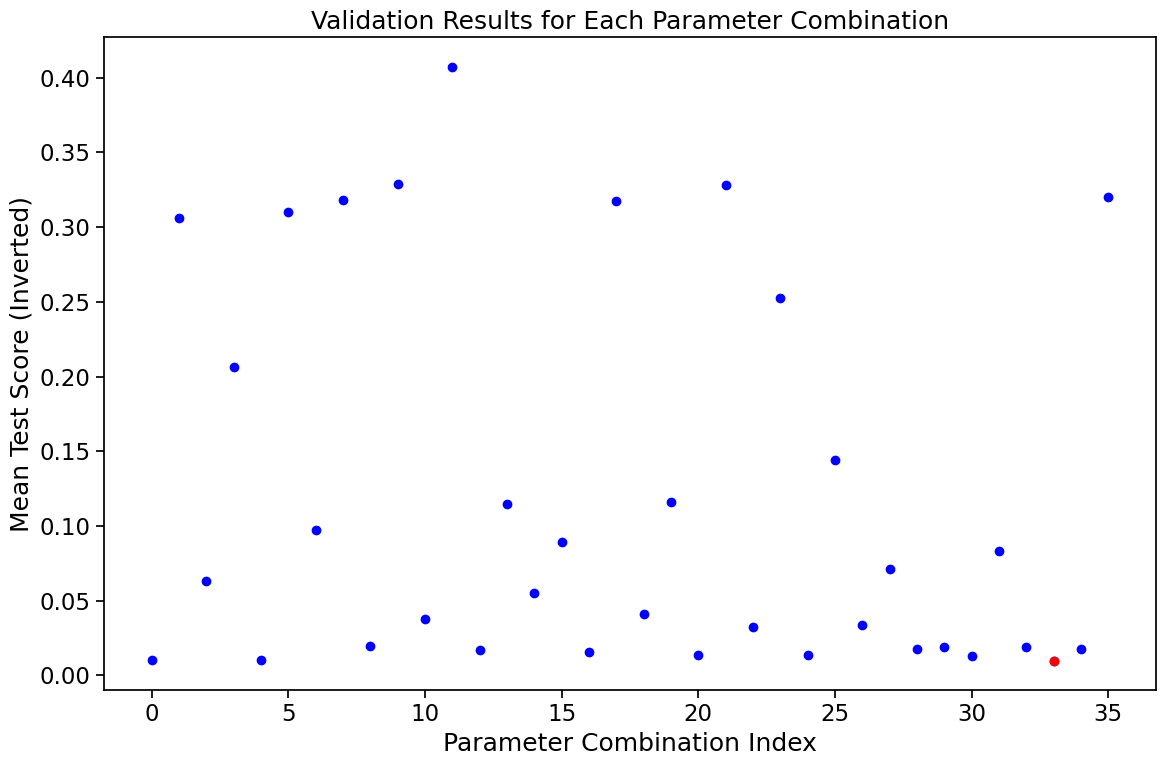

In [ ]:
import matplotlib.pyplot as plt

# Setup figure and axis
fig, ax = plt.subplots(figsize=(12, 8))

# Invert negative MSE to make higher scores appear better
gs_results['mean_test_score_inverted'] = gs_results['mean_test_score'] * -1

# Identify the index of the best (maximum) score
best_index = gs_results['mean_test_score_inverted'].idxmin()

# Plot all mean test scores
ax.scatter(range(len(gs_results)), gs_results['mean_test_score_inverted'], color='blue')

# Highlight the best score in red
ax.scatter(best_index, gs_results['mean_test_score_inverted'].loc[best_index], color='red')

# Set plot titles and labels
ax.set_title('Validation Results for Each Parameter Combination')
ax.set_xlabel('Parameter Combination Index')
ax.set_ylabel('Mean Test Score (Inverted)')

# Adjust layout to make sure everything fits well
plt.tight_layout()

# Show the plot
plt.show()


In [ ]:
# Assuming 'gs_results' is your DataFrame
# Convert mean_test_score to positive values if they're currently negative
gs_results['mean_test_score_positive'] = gs_results['mean_test_score'] * -1

# Create a pivot table
pivot_table = gs_results.pivot_table(
    values='mean_test_score_positive',
    index='param_module__hidden_dim',  # Rows will represent hidden dimensions
    columns='param_module__n_layers',  # Columns will represent the number of layers
    aggfunc='max'  # Max function to use if multiple entries exist for the same combination
)

# Check the pivot table
print(pivot_table)

NameError: name 'gs_results' is not defined

In [ ]:
#TODO retrain on entire dataset with best parameters
#Test on test set
# same for wind data and 24h prediction data
#Best parameters: {'batch_size': 64, 'iterator_train__shuffle': False, 'max_epochs': 80, 'module__drop_prob': 0.5, 'module__hidden_dim': 64, 'module__n_layers': 1, 'optimizer__lr': 0.001, 'optimizer__weight_decay': 0.001}


In [ ]:
gs = GridSearchCV(net, params, refit=False, cv=ps_wind, scoring='neg_mean_squared_error', verbose=2)
gs.fit(wind_X_combined, wind_y_combined)

Fitting 1 folds for each of 36 candidates, totalling 36 fits


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.1475        0.1993  3.0150
      2        0.1395        0.1808  2.3048
      3        0.1323        0.1363  2.6862
      4        0.1255        0.1194  2.5643
      5        0.1061        0.0975  2.1683
      6        0.0949        0.0572  2.1620
      7        0.0507        0.0187  2.1470
      8        0.0290        0.0480  2.2176
      9        0.0212        0.0194  2.6967
     10        0.0161        0.0327  2.4295
     11        0.0142        0.0524  2.1608
     12        0.0165        0.0360  2.1685
     13        0.0158        0.0463  2.1923
     14        0.0134        0.0137  2.1630
     15        0.0115        0.0089  2.8199
     16        0.0111        0.0377  2.4077
     17        0.0112        0.0669  2.1861
     18        0.0113        0.0552  2.1961
     19        0.0111        0.0463  2.1607
     20        0.0119        0.1122  2.2614
     21        0.0104        0.0

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.1662        0.2186  2.2308
      2        0.1440        0.2020  2.1781
      3        0.1329        0.1537  2.1761
      4        0.1115        0.0992  2.7338
      5        0.1102        0.0987  2.5964
      6        0.0962        0.0932  2.1756
      7        0.0625        0.0935  2.1963
      8        0.0668        0.0785  2.1569
      9        0.0309        0.0560  2.1438
     10        0.0295        0.0637  2.6280
     11        0.0268        0.0664  2.5423
     12        0.0258        0.0689  2.2190
     13        0.0251        0.0679  2.1727
     14        0.0207        0.0747  2.1572
     15        0.0185        0.0532  2.1561
     16        0.0155        0.0580  2.7865
     17        0.0122        0.1264  2.5087
     18        0.0118        0.1444  2.1930
     19        0.0129        0.1400  2.2274
     20        0.0106        0.1389  2.1753
     21        0.0106        0.0

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.1559        0.2032  2.8424
      2        0.1376        0.1588  2.1688
      3        0.1226        0.1230  2.1399
      4        0.0919        0.1183  2.1444
      5        0.1041        0.0988  2.1375
      6        0.0910        0.0384  2.4686
      7        0.0521        0.0854  2.7577
      8        0.0463        0.0703  2.1617
      9        0.0643        0.0654  2.1533
     10        0.0297        0.0198  2.1434
     11        0.0170        0.0760  2.1652
     12        0.0188        0.0286  2.4718
     13        0.0177        0.0220  2.7204
     14        0.0131        0.0081  2.1532
     15        0.0149        0.0191  2.1837
     16        0.0150        0.0218  2.1544
     17        0.0102        0.0098  2.1693
     18        0.0102        0.0436  2.5048
     19        0.0095        0.0734  2.6928
     20        0.0113        0.0490  2.1766
     21        0.0114        0.0

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.1467        0.2003  2.1604
      2        0.1421        0.1768  2.3829
      3        0.1360        0.1535  2.7999
      4        0.1309        0.1745  2.1710
      5        0.1155        0.1348  2.2061
      6        0.1022        0.1170  2.1835
      7        0.0703        0.0508  2.1831
      8        0.0443        0.1643  2.4556
      9        0.0891        0.1149  2.6755
     10        0.0343        0.0198  2.1759
     11        0.0214        0.0291  2.1781
     12        0.0172        0.0661  2.1484
     13        0.0148        0.0869  2.1779
     14        0.0141        0.0844  2.5796
     15        0.0128        0.1465  2.6403
     16        0.0112        0.1285  2.1757
     17        0.0153        0.1831  2.1644
     18        0.0123        0.1457  2.2025
     19        0.0098        0.1173  2.1715
     20        0.0094        0.1676  2.6384
     21        0.0100        0.1

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.1556        0.2426  2.8400
      2        0.1511        0.2336  2.6019
      3        0.1460        0.1973  2.1894
      4        0.1253        0.1761  2.1555
      5        0.1072        0.1323  2.1558
      6        0.1022        0.0841  2.1830
      7        0.0940        0.1119  2.7423
      8        0.0704        0.0622  2.4143
      9        0.0792        0.0602  2.1757
     10        0.0505        0.1018  2.1461
     11        0.0455        0.0436  2.1590
     12        0.0225        0.0163  2.2961
     13        0.0197        0.0302  2.8055
     14        0.0171        0.0179  2.2970
     15        0.0296        0.0934  2.1599
     16        0.0255        0.0820  2.1536
     17        0.0164        0.0910  2.1984
     18        0.0172        0.0496  2.3561
     19        0.0140        0.0475  2.8152
     20        0.0151        0.0400  2.1518
     21        0.0152        0.0

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.1548        0.2776  2.2022
      2        0.1553        0.2626  2.2698
      3        0.1499        0.2615  2.8015
      4        0.1434        0.2246  2.2944
      5        0.1318        0.2184  2.2029
      6        0.1192        0.1345  2.1611
      7        0.1077        0.0831  2.1940
      8        0.0986        0.1419  2.3696
      9        0.0963        0.1198  2.8306
     10        0.0940        0.1077  2.1830
     11        0.0792        0.0634  2.2088
     12        0.0615        0.0822  2.1666
     13        0.0337        0.0718  2.1843
     14        0.0335        0.0366  2.5155
     15        0.0232        0.0474  2.7302
     16        0.0156        0.0670  2.1594
     17        0.0143        0.0708  2.1697
     18        0.0128        0.1226  2.1858
     19        0.0128        0.1025  2.2225
     20        0.0115        0.0724  2.6175
     21        0.0107        0.1

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.1506        0.1994  1.4632
      2        0.1269        0.1691  1.1674
      3        0.1217        0.1073  1.1574
      4        0.1057        0.1022  1.1623
      5        0.0943        0.1302  1.1667
      6        0.0956        0.1003  1.1513
      7        0.0839        0.1476  1.1586
      8        0.1041        0.0366  1.1600
      9        0.0733        0.0432  1.1621
     10        0.0596        0.0206  1.5166
     11        0.0242        0.0470  1.5460
     12        0.0201        0.0459  1.3444
     13        0.0166        0.0534  1.1485
     14        0.0160        0.0590  1.1676
     15        0.0143        0.0337  1.1660
     16        0.0126        0.0291  1.1498
     17        0.0122        0.0312  1.1913
     18        0.0113        0.0294  1.1658
     19        0.0110        0.0337  1.1513
     20        0.0107        0.0326  1.1685
     21        0.0096        0.0

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.1603        0.2257  1.1473
      2        0.1426        0.1910  1.1582
      3        0.1365        0.1771  1.1509
      4        0.1270        0.1601  1.1519
      5        0.1217        0.1584  1.1602
      6        0.1225        0.0987  1.2990
      7        0.1106        0.1097  1.4821
      8        0.1055        0.0584  1.5624
      9        0.0824        0.0429  1.2182
     10        0.0539        0.0400  1.1520
     11        0.0324        0.0321  1.1308
     12        0.0221        0.0329  1.1533
     13        0.0205        0.0199  1.1543
     14        0.0191        0.0422  1.1653
     15        0.0172        0.0452  1.1802
     16        0.0167        0.0364  1.1494
     17        0.0163        0.0381  1.2581
     18        0.0161        0.0357  1.4785
     19        0.0148        0.0337  1.5612
     20        0.0143        0.0281  1.1852
     21        0.0139        0.0

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.1596        0.2071  1.1612
      2        0.1441        0.1937  1.1865
      3        0.1365        0.1697  1.1622
      4        0.1198        0.1149  1.1516
      5        0.0970        0.1095  1.1512
      6        0.0752        0.0630  1.1934
      7        0.0334        0.0354  1.5181
      8        0.0332        0.0433  1.5043
      9        0.0292        0.0574  1.3219
     10        0.0222        0.0278  1.1509
     11        0.0160        0.0285  1.1427
     12        0.0139        0.0220  1.1433
     13        0.0121        0.0469  1.1372
     14        0.0116        0.0566  1.1649
     15        0.0116        0.0652  1.1583
     16        0.0104        0.0585  1.1735
     17        0.0096        0.0600  1.1968
     18        0.0099        0.0739  1.4889
     19        0.0095        0.0644  1.5415
     20        0.0098        0.0481  1.2447
     21        0.0080        0.0

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.1545        0.1852  1.2000
      2        0.1460        0.1746  1.1454
      3        0.1374        0.1596  1.2573
      4        0.1246        0.1509  1.5004
      5        0.1315        0.1470  1.5242
      6        0.1142        0.1175  1.2460
      7        0.0997        0.1179  1.1390
      8        0.0937        0.0557  1.1274
      9        0.0744        0.0323  1.1494
     10        0.0421        0.0414  1.1413
     11        0.0240        0.0263  1.1400
     12        0.0184        0.0173  1.1460
     13        0.0155        0.0245  1.1395
     14        0.0148        0.0338  1.2180
     15        0.0152        0.0321  1.5000
     16        0.0141        0.0322  1.5090
     17        0.0142        0.0411  1.2688
     18        0.0130        0.0268  1.1591
     19        0.0125        0.0186  1.1627
     20        0.0107        0.0196  1.1659
     21        0.0101        0.0

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.1669        0.1838  1.1540
      2        0.1435        0.1624  1.1563
      3        0.1373        0.1298  1.1802
      4        0.1103        0.0829  1.3833
      5        0.1072        0.0753  1.4846
      6        0.1057        0.0742  1.4325
      7        0.0829        0.0585  1.1388
      8        0.0723        0.0845  1.1513
      9        0.0598        0.0370  1.1587
     10        0.0295        0.0213  1.1680
     11        0.0219        0.0143  1.1453
     12        0.0201        0.0297  1.1698
     13        0.0176        0.0476  1.1545
     14        0.0158        0.0212  1.1731
     15        0.0144        0.0218  1.4374
     16        0.0141        0.0238  1.5139
     17        0.0124        0.0329  1.4634
     18        0.0127        0.0216  1.1719
     19        0.0109        0.0341  1.1622
     20        0.0113        0.0285  1.2179
     21        0.0104        0.0

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.1521        0.1917  1.5146
      2        0.1424        0.1502  1.5868
      3        0.1339        0.1465  1.2139
      4        0.1291        0.1379  1.1714
      5        0.1025        0.0657  1.1596
      6        0.0971        0.0727  1.1647
      7        0.0974        0.0489  1.1899
      8        0.0844        0.0641  1.1489
      9        0.0678        0.1353  1.1852
     10        0.0533        0.0626  1.1433
     11        0.0308        0.0795  1.3251
     12        0.0270        0.0517  1.4934
     13        0.0213        0.0464  1.5901
     14        0.0186        0.0939  1.1876
     15        0.0222        0.0368  1.1899
     16        0.0156        0.0181  1.1791
     17        0.0135        0.0183  1.1849
     18        0.0149        0.0313  1.1912
     19        0.0148        0.0317  1.1733
     20        0.0128        0.0308  1.1595
     21        0.0113        0.0

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.2034        0.2237  0.7001
      2        0.1670        0.2172  0.6586
      3        0.1565        0.2018  0.6403
      4        0.1488        0.1575  0.6510
      5        0.1404        0.1729  0.6398
      6        0.1400        0.1057  0.6470
      7        0.1253        0.1057  0.6534
      8        0.1229        0.1218  0.6490
      9        0.1002        0.0516  0.6595
     10        0.0536        0.0531  0.6526
     11        0.0252        0.0308  0.7309
     12        0.0200        0.0522  0.8792
     13        0.0172        0.0402  0.8517
     14        0.0151        0.0400  0.9042
     15        0.0140        0.0351  0.8177
     16        0.0129        0.0346  0.6511
     17        0.0122        0.0313  0.6463
     18        0.0123        0.0286  0.6435
     19        0.0110        0.0278  0.6427
     20        0.0107        0.0303  0.6457
     21        0.0103        0.0

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.2197        0.1953  0.6380
      2        0.1598        0.1886  0.6686
      3        0.1460        0.1815  0.6651
      4        0.1351        0.1510  0.6513
      5        0.1204        0.1181  0.6875
      6        0.1022        0.1307  0.6495
      7        0.0614        0.0659  0.6545
      8        0.0408        0.0429  0.7229
      9        0.0240        0.0233  0.8489
     10        0.0205        0.0217  0.8581
     11        0.0197        0.0254  0.8582
     12        0.0189        0.0342  0.8967
     13        0.0178        0.0328  0.6872
     14        0.0161        0.0261  0.6495
     15        0.0147        0.0329  0.6440
     16        0.0140        0.0319  0.6500
     17        0.0134        0.0283  0.6337
     18        0.0129        0.0198  0.6498
     19        0.0120        0.0297  0.6665
     20        0.0124        0.0303  0.6540
     21        0.0116        0.0

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.1610        0.2081  0.6536
      2        0.1404        0.1868  0.6624
      3        0.1265        0.1460  0.6417
      4        0.1124        0.1088  0.6690
      5        0.1026        0.0822  0.6523
      6        0.1082        0.0643  0.6428
      7        0.0903        0.0404  0.6480
      8        0.0375        0.0894  0.6693
      9        0.0258        0.0227  0.6510
     10        0.0181        0.0270  0.6778
     11        0.0159        0.0389  0.8954
     12        0.0149        0.0199  0.8577
     13        0.0144        0.0173  0.8348
     14        0.0131        0.0303  0.8991
     15        0.0117        0.0327  0.7420
     16        0.0117        0.0160  0.6423
     17        0.0106        0.0142  0.6529
     18        0.0105        0.0216  0.6442
     19        0.0097        0.0316  0.6525
     20        0.0098        0.0310  0.6361
     21        0.0098        0.0

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.1580        0.2274  0.6416
      2        0.1525        0.2182  0.6579
      3        0.1364        0.1809  0.6508
      4        0.1232        0.1758  0.6304
      5        0.1160        0.1161  0.6534
      6        0.1022        0.0828  0.6368
      7        0.0912        0.1053  0.6545
      8        0.0644        0.0518  0.6437
      9        0.0446        0.0761  0.7828
     10        0.0242        0.0199  0.8502
     11        0.0197        0.0290  0.8411
     12        0.0191        0.0410  0.8917
     13        0.0166        0.0536  0.8080
     14        0.0156        0.0267  0.6877
     15        0.0132        0.0193  0.6533
     16        0.0132        0.0220  0.6993
     17        0.0136        0.0392  0.6797
     18        0.0119        0.0498  0.6607
     19        0.0125        0.0366  0.6593
     20        0.0110        0.0185  0.6518
     21        0.0107        0.0

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.1783        0.2149  0.6458
      2        0.1400        0.1835  0.6552
      3        0.1315        0.1397  0.6569
      4        0.1201        0.1186  0.6577
      5        0.1111        0.0887  0.6521
      6        0.1097        0.0904  0.6565
      7        0.0958        0.0799  0.6466
      8        0.0706        0.0645  0.6559
      9        0.0436        0.0797  0.6591
     10        0.0247        0.0551  0.7461
     11        0.0259        0.0468  0.8552
     12        0.0195        0.0557  0.8528
     13        0.0172        0.0482  0.8806
     14        0.0163        0.0318  0.8014
     15        0.0144        0.0304  0.6599
     16        0.0148        0.0376  0.6472
     17        0.0142        0.0664  0.6445
     18        0.0138        0.0484  0.6581
     19        0.0131        0.0466  0.6494
     20        0.0119        0.0438  0.6475
     21        0.0112        0.0

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.1669        0.2491  0.6924
      2        0.1438        0.1991  0.6606
      3        0.1334        0.1723  0.6603
      4        0.1179        0.1598  0.6376
      5        0.1112        0.1276  0.6561
      6        0.1119        0.1173  0.6627
      7        0.1026        0.1680  0.8658
      8        0.0877        0.0625  0.9018
      9        0.0563        0.0529  0.8514
     10        0.0330        0.0428  0.9121
     11        0.0277        0.0607  0.7207
     12        0.0282        0.0795  0.6668
     13        0.0259        0.1131  0.6959
     14        0.0218        0.1112  0.6847
     15        0.0206        0.0824  0.6775
     16        0.0189        0.0594  0.6598
     17        0.0170        0.0592  0.6493
     18        0.0164        0.0785  0.6529
     19        0.0161        0.0671  0.6710
     20        0.0148        0.0743  0.6552
     21        0.0151        0.0

GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             estimator=<class 'skorch.regressor.NeuralNetRegressor'>[uninitialized](
  module=<class 'GRU_model.GRUNet'>,
  module__input_dim=11,
  module__output_dim=1,
),
             param_grid={'batch_size': [16, 32, 64],
                         'iterator_train__shuffle': [False], 'max_epochs': [80],
                         'module__drop_prob': [0.5],
                         'module__hidden_dim': [16, 32, 64],
                         'module__n_layers': [1, 2], 'optimizer__lr': [0.001],
                         'optimizer__weight_decay': [0.0001, 0.001]},
             refit=False, scoring='neg_mean_squared_error', verbose=2)

In [ ]:
best_parameters_wind = gs.best_params_
best_score_wind = gs.best_score_
print("Best parameters:", best_parameters_wind)
print("Best score (negative MSE):", best_score_wind)

Best parameters: {'batch_size': 16, 'iterator_train__shuffle': False, 'max_epochs': 80, 'module__drop_prob': 0.5, 'module__hidden_dim': 16, 'module__n_layers': 1, 'optimizer__lr': 0.001, 'optimizer__weight_decay': 0.0001}
Best score (negative MSE): -0.001339736278168857


In [19]:
#Best parameters: batch_size': 16, 'iterator_train__shuffle': False, 'max_epochs': 80, 'module__drop_prob': 0.5, 'module__hidden_dim': 16, 'module__n_layers': 1, 'optimizer__lr': 0.001, 'optimizer__weight_decay': 0.0001
gs_results_wind = pd.DataFrame(gs.cv_results_)
gs_results_wind
gs_results_wind.to_csv('/content/drive/MyDrive/solar_data/gird_search_results_wind.csv')

NameError: name 'gs' is not defined

In [20]:
solar_24_X, solar_24_y = move_sliding_window_2(solar_data, WINDOW_SIZE, range(11), 0, forecast_horizon=24)
solar_24_val_X, solar_24_val_y =  move_sliding_window_2(solar_data_val, WINDOW_SIZE, range(11), 0, forecast_horizon=24)
wind_24_X, wind_24_y = move_sliding_window_2(wind_data, WINDOW_SIZE, range(11), 0, forecast_horizon=24)
wind_24_val_X, wind_24_val_y = move_sliding_window_2(wind_data_val, WINDOW_SIZE, range(11), 0, forecast_horizon=24)

(17496, 25, 11) (17496, 1)
(8712, 25, 11) (8712, 1)
(17496, 25, 11) (17496, 1)
(8712, 25, 11) (8712, 1)


In [44]:
gs_24_solar = GridSearchCV(net, params, refit=False, cv=ps_solar_24, scoring='neg_mean_squared_error', verbose=2)
gs_24_solar.fit(solar_X_combined_24, solar_y_combined_24)

NameError: name 'net' is not defined

In [ ]:
best_parameters_solar_24 = gs_24_solar.best_params_
best_score_solar_24 = gs_24_solar.best_score_
print("Best parameters:", best_parameters_solar_24)
print("Best score (negative MSE):", best_score_solar_24)

Best parameters: {'batch_size': 64, 'iterator_train__shuffle': False, 'max_epochs': 80, 'module__drop_prob': 0.5, 'module__hidden_dim': 16, 'module__n_layers': 1, 'optimizer__lr': 0.001, 'optimizer__weight_decay': 0.0001}
Best score (negative MSE): -0.03249602019786835


In [ ]:
gs_results = pd.DataFrame(gs_24_solar.cv_results_)
gs_results
gs_results.to_csv('/content/drive/MyDrive/solar_data/gird_search_results_solar_24.csv')

In [ ]:
gs_wind_24 = GridSearchCV(net, params, refit=False, cv=ps_wind_24, scoring='neg_mean_squared_error', verbose=2)
gs_wind_24.fit(wind_X_combined_24, wind_y_combined_24)

Fitting 1 folds for each of 36 candidates, totalling 36 fits


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.1735        0.1965  2.6803
      2        0.1516        0.1971  2.1412
      3        0.1402        0.2018  2.1740
      4        0.1368        0.1978  2.7525
      5        0.1354        0.1969  2.4575
      6        0.1346        0.1969  2.1409
      7        0.1336        0.1975  2.1378
      8        0.1330        0.1935  2.1358
      9        0.1330        0.1941  2.0920
     10        0.1321        0.1887  2.7428
     11        0.1314        0.1863  2.4259
     12        0.1313        0.1819  2.1197
     13        0.1312        0.1779  2.1276
     14        0.1308        0.1740  2.1411
     15        0.1304        0.1698  2.1304
     16        0.1323        0.1726  2.6836
     17        0.1337        0.1633  2.4277
     18        0.1320        0.1590  2.1313
     19        0.1315        0.1565  2.1850
     20        0.1314        0.1551  2.1542
     21        0.1319        0.1

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.1531        0.2097  2.3938
      2        0.1495        0.2143  2.1488
      3        0.1499        0.2079  2.1271
      4        0.1450        0.2071  2.1272
      5        0.1422        0.2050  2.1711
      6        0.1420        0.2040  2.7562
      7        0.1388        0.2053  2.3354
      8        0.1367        0.2034  2.1359
      9        0.1353        0.2021  2.1376
     10        0.1351        0.1978  2.1287
     11        0.1340        0.1976  2.1779
     12        0.1344        0.1973  2.8892
     13        0.1335        0.1938  2.4202
     14        0.1336        0.1919  2.1911
     15        0.1331        0.1907  2.2866
     16        0.1334        0.1853  2.3894
     17        0.1321        0.1845  2.5346
     18        0.1318        0.1798  3.1040
     19        0.1313        0.1810  2.3977
     20        0.1314        0.1857  2.3192
     21        0.1319        0.1

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.1536        0.2251  2.6272
      2        0.1508        0.2154  2.9592
      3        0.1448        0.2150  2.4785
      4        0.1450        0.2108  2.1238
      5        0.1425        0.2190  2.1257
      6        0.1415        0.2089  2.1161
      7        0.1408        0.2071  2.1205
      8        0.1380        0.2079  2.5829
      9        0.1365        0.2060  2.5554
     10        0.1347        0.2021  2.1036
     11        0.1347        0.2045  2.1251
     12        0.1335        0.1906  2.1204
     13        0.1321        0.1917  2.1195
     14        0.1317        0.1899  2.5664
     15        0.1311        0.1822  2.4387
     16        0.1299        0.1780  2.1324
     17        0.1297        0.1741  2.1237
     18        0.1291        0.1690  2.1301
     19        0.1311        0.1755  2.1179
     20        0.1265        0.1603  2.6088
     21        0.1230        0.1

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.1489        0.2148  2.1387
      2        0.1479        0.2160  2.1263
      3        0.1462        0.2175  2.1230
      4        0.1451        0.2208  2.7285
      5        0.1462        0.2220  2.2697
      6        0.1447        0.2264  2.1663
      7        0.1457        0.2288  2.1550
      8        0.1458        0.2267  2.1508
      9        0.1435        0.2323  2.3221
     10        0.1458        0.2359  2.8014
     11        0.1440        0.2336  2.1556
     12        0.1446        0.2416  2.1643
     13        0.1453        0.2465  2.1187
     14        0.1448        0.2520  2.1085
     15        0.1449        0.2480  2.3032
     16        0.1451        0.2486  2.7693
     17        0.1434        0.2440  2.1185
     18        0.1443        0.2522  2.1121
     19        0.1455        0.2663  2.1573
     20        0.1442        0.2448  2.1050
     21        0.1458        0.2

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.1532        0.2376  2.6028
      2        0.1530        0.2247  2.1141
      3        0.1519        0.2220  2.1611
      4        0.1497        0.2210  2.5851
      5        0.1477        0.2233  2.7499
      6        0.1466        0.2230  2.7746
      7        0.1464        0.2177  2.1805
      8        0.1447        0.2236  2.1318
      9        0.1440        0.2267  2.1289
     10        0.1436        0.2208  2.1328
     11        0.1415        0.2391  2.2954
     12        0.1401        0.2392  2.8062
     13        0.1383        0.2380  2.1294
     14        0.1369        0.2320  2.1240
     15        0.1353        0.2251  2.1365
     16        0.1349        0.2207  2.1318
     17        0.1343        0.2156  2.3153
     18        0.1337        0.2099  2.7112
     19        0.1327        0.2001  2.1337
     20        0.1318        0.1956  2.1689
     21        0.1314        0.1

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.1567        0.2787  2.8897
      2        0.1566        0.2608  3.2393
      3        0.1548        0.2584  2.1470
      4        0.1541        0.2626  2.1358
      5        0.1523        0.2649  2.1373
      6        0.1518        0.2458  2.1197
      7        0.1495        0.2405  2.5020
      8        0.1486        0.2387  2.5131
      9        0.1472        0.2295  2.1342
     10        0.1455        0.2188  2.1561
     11        0.1443        0.2174  2.1267
     12        0.1431        0.2141  2.1298
     13        0.1431        0.2190  2.5982
     14        0.1411        0.2029  2.4734
     15        0.1393        0.2000  2.1101
     16        0.1383        0.1957  2.1221
     17        0.1383        0.1905  2.1184
     18        0.1378        0.1844  2.1206
     19        0.1365        0.1838  2.5985
     20        0.1354        0.1843  2.4595
     21        0.1361        0.1

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.1546        0.2339  1.1383
      2        0.1425        0.2254  1.1415
      3        0.1398        0.2194  1.1388
      4        0.1356        0.2127  1.1336
      5        0.1297        0.2120  1.1385
      6        0.1259        0.2068  1.4049
      7        0.1233        0.2103  1.4880
      8        0.1217        0.2027  1.4079
      9        0.1219        0.1952  1.1587
     10        0.1241        0.1998  1.3897
     11        0.1192        0.2031  1.3526
     12        0.1166        0.1739  1.4666
     13        0.1154        0.1709  1.3362
     14        0.1140        0.1463  1.1312
     15        0.1137        0.1354  1.1384
     16        0.1136        0.1413  1.3290
     17        0.1107        0.1378  1.4696
     18        0.1075        0.1355  1.4827
     19        0.1058        0.1399  1.1365
     20        0.1020        0.1411  1.1377
     21        0.0972        0.1

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.1616        0.2056  1.1786
      2        0.1551        0.2015  1.4869
      3        0.1554        0.2008  1.5027
      4        0.1461        0.1968  1.1997
      5        0.1498        0.1941  1.1392
      6        0.1476        0.1899  1.1561
      7        0.1421        0.1999  1.1393
      8        0.1426        0.1904  1.1360
      9        0.1407        0.1836  1.1336
     10        0.1396        0.1825  1.1538
     11        0.1387        0.1825  1.1384
     12        0.1382        0.1798  1.2071
     13        0.1379        0.1773  1.4648
     14        0.1375        0.1752  1.5017
     15        0.1372        0.1733  1.2210
     16        0.1369        0.1722  1.1416
     17        0.1366        0.1718  1.1395
     18        0.1364        0.1721  1.1426
     19        0.1363        0.1722  1.1374
     20        0.1361        0.1725  1.1372
     21        0.1359        0.1

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.1767        0.1935  1.2455
      2        0.1440        0.2002  1.1372
      3        0.1402        0.1955  1.1307
      4        0.1331        0.1915  1.1335
      5        0.1281        0.1882  1.1323
      6        0.1247        0.1855  1.1280
      7        0.1224        0.1822  1.1394
      8        0.1202        0.1857  1.1287
      9        0.1197        0.1823  1.1625
     10        0.1186        0.1770  1.4888
     11        0.1178        0.1634  1.5143
     12        0.1164        0.1673  1.2225
     13        0.1154        0.1670  1.1523
     14        0.1150        0.1653  1.3766
     15        0.1138        0.1361  1.3799
     16        0.1130        0.1995  1.4815
     17        0.1155        0.1520  1.4007
     18        0.1148        0.1653  1.1604
     19        0.1126        0.1471  1.2039
     20        0.1189        0.2331  1.4823
     21        0.1167        0.2

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.1696        0.2166  1.1556
      2        0.1483        0.2112  1.1522
      3        0.1479        0.2067  1.1779
      4        0.1460        0.2032  1.1615
      5        0.1431        0.2001  1.4980
      6        0.1411        0.1995  1.4921
      7        0.1409        0.1980  1.3084
      8        0.1393        0.1997  1.1612
      9        0.1385        0.1947  1.1499
     10        0.1377        0.1998  1.1521
     11        0.1401        0.1910  1.1482
     12        0.1374        0.1958  1.1358
     13        0.1367        0.1897  1.1381
     14        0.1362        0.1866  1.1466
     15        0.1307        0.1939  1.1386
     16        0.1351        0.1816  1.4814
     17        0.1340        0.1748  1.4752
     18        0.1269        0.1777  1.3279
     19        0.1333        0.1749  1.1437
     20        0.1336        0.1730  1.1428
     21        0.1341        0.1

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.1612        0.2066  1.1736
      2        0.1509        0.2087  1.4572
      3        0.1524        0.2044  1.4761
      4        0.1531        0.1969  1.2968
      5        0.1468        0.1944  1.1364
      6        0.1451        0.1891  1.1550
      7        0.1411        0.1873  1.1412
      8        0.1394        0.1841  1.1408
      9        0.1382        0.1800  1.1402
     10        0.1362        0.1725  1.1562
     11        0.1344        0.1702  1.1394
     12        0.1335        0.1661  1.1363
     13        0.1328        0.1623  1.4747
     14        0.1322        0.1590  1.4772
     15        0.1317        0.1574  1.2627
     16        0.1313        0.1569  1.1712
     17        0.1309        0.1543  1.2562
     18        0.1306        0.1558  1.4240
     19        0.1304        0.1564  1.3957
     20        0.1303        0.1508  1.4771
     21        0.1300        0.1

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.1632        0.2048  1.1511
      2        0.1504        0.1985  1.1323
      3        0.1505        0.1935  1.1434
      4        0.1486        0.1912  1.1397
      5        0.1440        0.1907  1.1417
      6        0.1435        0.1913  1.1372
      7        0.1419        0.1862  1.1463
      8        0.1406        0.1848  1.4116
      9        0.1400        0.1853  1.4828
     10        0.1392        0.1836  1.3907
     11        0.1382        0.1829  1.1417
     12        0.1358        0.1785  1.1427
     13        0.1368        0.1725  1.1393
     14        0.1336        0.1719  1.1408
     15        0.1304        0.1666  1.1309
     16        0.1298        0.1661  1.1358
     17        0.1283        0.1657  1.1289
     18        0.1308        0.1723  1.1465
     19        0.1309        0.1519  1.3576
     20        0.1301        0.1692  1.4641
     21        0.1272        0.1

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.2969        0.2420  0.8386
      2        0.1648        0.2420  0.8566
      3        0.1573        0.2223  0.8553
      4        0.1498        0.2351  0.8387
      5        0.1529        0.2197  0.6272
      6        0.1484        0.2045  0.6387
      7        0.1430        0.2000  0.6386
      8        0.1426        0.2186  0.6302
      9        0.1427        0.1978  0.6340
     10        0.1432        0.1792  0.6308
     11        0.1326        0.1915  0.6349
     12        0.1337        0.1669  0.6353
     13        0.1302        0.2073  0.6297
     14        0.1279        0.1542  0.6375
     15        0.1292        0.1950  0.6369
     16        0.1199        0.1597  0.6319
     17        0.1165        0.2033  0.6403
     18        0.1134        0.1644  0.6292
     19        0.1127        0.1803  0.6385
     20        0.1094        0.1710  0.7450
     21        0.1088        0.1

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.3230        0.2351  0.7099
      2        0.1589        0.2383  0.6296
      3        0.1512        0.2277  0.6283
      4        0.1539        0.2216  0.6333
      5        0.1483        0.2141  0.6338
      6        0.1538        0.2066  0.6282
      7        0.1391        0.1945  0.6373
      8        0.1463        0.1882  0.6293
      9        0.1399        0.1817  0.6349
     10        0.1470        0.1729  0.6326
     11        0.1298        0.1525  0.6269
     12        0.1397        0.1502  0.6583
     13        0.1346        0.1330  0.6362
     14        0.1299        0.1475  0.6307
     15        0.1313        0.1879  0.6343
     16        0.1321        0.1914  0.6255
     17        0.1294        0.1879  0.8392
     18        0.1247        0.1772  0.8450
     19        0.1197        0.1604  0.8351
     20        0.1192        0.1547  0.8753
     21        0.1149        0.1

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.1649        0.2477  0.7768
      2        0.1561        0.2276  0.6370
      3        0.1444        0.2174  0.6353
      4        0.1417        0.2045  0.6259
      5        0.1431        0.2124  0.6345
      6        0.1369        0.1832  0.6336
      7        0.1339        0.1798  0.6286
      8        0.1299        0.1792  0.6474
      9        0.1267        0.1672  0.6264
     10        0.1277        0.1506  0.6367
     11        0.1251        0.1780  0.6382
     12        0.1234        0.1957  0.6273
     13        0.1220        0.1755  0.6414
     14        0.1223        0.1520  0.6393
     15        0.1191        0.1512  0.6300
     16        0.1145        0.2149  0.6406
     17        0.1144        0.1507  0.7926
     18        0.1120        0.1331  0.8291
     19        0.1099        0.2676  0.8266
     20        0.1116        0.1498  0.8831
     21        0.1072        0.1

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.2031        0.2137  0.6470
      2        0.1613        0.2183  0.6283
      3        0.1564        0.2093  0.6346
      4        0.1493        0.2062  0.6270
      5        0.1408        0.2115  0.6337
      6        0.1360        0.2119  0.6378
      7        0.1340        0.1804  0.6551
      8        0.1291        0.1799  0.6327
      9        0.1261        0.1581  0.6372
     10        0.1239        0.2257  0.6299
     11        0.1242        0.2210  0.6318
     12        0.1241        0.1858  0.6298
     13        0.1227        0.2059  0.7436
     14        0.1189        0.1813  0.8350
     15        0.1150        0.1839  0.8319
     16        0.1113        0.1314  0.8908
     17        0.1093        0.1337  0.7428
     18        0.1080        0.1441  0.6356
     19        0.1087        0.1298  0.6317
     20        0.1073        0.1277  0.6319
     21        0.1051        0.1

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.2020        0.2816  0.6412
      2        0.1468        0.2714  0.6357
      3        0.1474        0.2257  0.6286
      4        0.1425        0.2004  0.6373
      5        0.1294        0.2460  0.6367
      6        0.1254        0.2070  0.6359
      7        0.1291        0.1978  0.6381
      8        0.1252        0.2263  0.6394
      9        0.1217        0.1850  0.6502
     10        0.1243        0.1832  0.6387
     11        0.1218        0.2087  0.6375
     12        0.1203        0.1891  0.8282
     13        0.1231        0.1863  0.8442
     14        0.1206        0.1824  0.8838
     15        0.1174        0.2079  0.8726
     16        0.1189        0.1713  0.6812
     17        0.1216        0.1823  0.6415
     18        0.1184        0.1942  0.6334
     19        0.1163        0.1843  0.6389
     20        0.1123        0.1876  0.6402
     21        0.1146        0.2

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.1515        0.2334  0.6469
      2        0.1442        0.2872  0.6542
      3        0.1558        0.2158  0.6408
      4        0.1469        0.2045  0.6438
      5        0.1342        0.2147  0.6413
      6        0.1303        0.2141  0.6466
      7        0.1301        0.2089  0.6472
      8        0.1255        0.2154  0.8106
      9        0.1237        0.2139  0.8597
     10        0.1241        0.1970  0.8382
     11        0.1239        0.2128  0.9075
     12        0.1250        0.2073  0.6537
     13        0.1221        0.1737  0.6398
     14        0.1246        0.1911  0.6529
     15        0.1177        0.2145  0.6391
     16        0.1212        0.2055  0.6490
     17        0.1220        0.1956  0.6493
     18        0.1210        0.1966  0.6396
     19        0.1236        0.2191  0.6694
     20        0.1234        0.2024  0.6515
     21        0.1205        0.1

GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             estimator=<class 'skorch.regressor.NeuralNetRegressor'>[uninitialized](
  module=<class 'GRU_model.GRUNet'>,
  module__input_dim=11,
  module__output_dim=1,
),
             param_grid={'batch_size': [16, 32, 64],
                         'iterator_train__shuffle': [False], 'max_epochs': [80],
                         'module__drop_prob': [0.5],
                         'module__hidden_dim': [16, 32, 64],
                         'module__n_layers': [1, 2], 'optimizer__lr': [0.001],
                         'optimizer__weight_decay': [0.0001, 0.001]},
             refit=False, scoring='neg_mean_squared_error', verbose=2)

In [ ]:
best_parameters_wind_24 = gs_wind_24.best_params_
best_score_wind_24 = gs_wind_24.best_score_
print("Best parameters:", best_parameters_wind_24)
print("Best score (negative MSE):", best_score_wind_24)

Best parameters: {'batch_size': 64, 'iterator_train__shuffle': False, 'max_epochs': 80, 'module__drop_prob': 0.5, 'module__hidden_dim': 16, 'module__n_layers': 1, 'optimizer__lr': 0.001, 'optimizer__weight_decay': 0.001}
Best score (negative MSE): -0.09689153730869293


In [ ]:
gs_results = pd.DataFrame(gs_wind_24.cv_results_)
gs_results
gs_results.to_csv('/content/drive/MyDrive/solar_data/gird_search_results_wind_24.csv')